# 코드공유에서 줍줍한 변수 하나가 있어서 이걸 적용해봅시다.

기온과 습도를 활용해서 td, t-td 를 만들어줍니다.

In [9]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')
import os, sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import numpy as np
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import KFold

In [10]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [25]:
train = ld.load_dtypes(TRAIN_PATH)
train.info()
submission = pd.read_csv(SUBMISSION_PATH)
test = ld.load_dtypes(TEST_PATH + '/0.csv')

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB
C:\Users\Wyatt\wyatt37\Data\solarpanel\test/0.csv


In [26]:
# hour와 minute을 합쳐주는 함수입니다.
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

In [27]:
def add_ttd_features(train):
    c = 243.12
    b = 17.62
    gamma = (b * (train['T']) / (c + (train['T']))) + np.log(train['RH'] / 100)
    dp = ( c * gamma) / (b - gamma)
    train.insert(1, 'TD', dp)
    train.insert(1, 'T-TD', train['T'] - train['TD'])
    
    return train

In [28]:
train = sum_hour_minute(train)
train = add_ttd_features(train)
train.shape

(52560, 11)

In [29]:
train

,Day,T-TD,TD,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,4.522271,-16.522271,0.0,0.0,0,0,1.5,69.080002,-12,0.0
1,0,4.525742,-16.525742,0.5,0.5,0,0,1.5,69.059998,-12,0.0
2,0,4.061777,-16.061777,1.0,0.0,0,0,1.6,71.779999,-12,0.0
3,0,4.066807,-16.066807,1.5,0.5,0,0,1.6,71.750000,-12,0.0
4,0,3.500215,-15.500215,2.0,0.0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,4.540094,-8.540094,21.5,0.5,0,0,2.4,70.699997,-4,0.0
52556,1094,5.268639,-9.268639,22.0,0.0,0,0,2.4,66.790001,-4,0.0
52557,1094,5.270551,-9.270551,22.5,0.5,0,0,2.2,66.779999,-4,0.0
52558,1094,5.091976,-9.091976,23.0,0.0,0,0,2.1,67.720001,-4,0.0


In [30]:
shifted_columns = ['T-TD', 'TD', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET']
lags = [48, 96, 144, 192, 240] # 뒤에서부터 하나씩 줄인다.

In [31]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
    return temp

In [32]:
# shift되지 않은 train은 test를 만들기 위해 필요합니다.
# 새로운 df로 받아줍시다.
train = shift_columns(train, shifted_columns, lags)
train.shape

(52560, 51)

In [33]:
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

In [34]:
# 학습에 쓰지 않을 변수들은 버려줍니다.
train.drop(['Day', 'Minute'], axis=1, inplace=True)

In [35]:
train.dropna(inplace=True)
train.shape

(52224, 51)

In [37]:
train.head()

,T-TD,TD,Hour,DHI,DNI,WS,RH,T,TARGET,T-TD_lag_48,TD_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,T-TD_lag_96,TD_lag_96,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,T-TD_lag_144,TD_lag_144,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,T-TD_lag_192,TD_lag_192,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,TARGET_lag_192,T-TD_lag_240,TD_lag_240,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240,TARGET_lag_240,TARGET_1,TARGET_2
240,3.510917,-2.510917,0.0,0,0,1.5,77.410004,1,0.0,4.252470,-9.252470,0.0,0.0,2.1,72.099998,-5.0,0.0,3.041638,-17.041638,0.0,0.0,1.8,77.760002,-14.0,0.0,3.856332,-11.856332,0.0,0.0,2.2,73.800003,-8.0,0.0,1.237331,-11.237331,0.0,0.0,1.6,90.660004,-10.0,0.0,4.522271,-16.522271,0.0,0.0,1.5,69.080002,-12.0,0.0,0.0,0.0
241,3.509173,-2.509173,0.5,0,0,1.7,77.419998,1,0.0,4.252470,-9.252470,0.0,0.0,2.0,72.099998,-5.0,0.0,3.066523,-16.066523,0.0,0.0,2.0,77.769997,-13.0,0.0,4.837397,-12.837397,0.0,0.0,2.1,68.199997,-8.0,0.0,1.234563,-11.234563,0.0,0.0,1.6,90.680000,-10.0,0.0,4.525742,-16.525742,0.0,0.0,1.5,69.059998,-12.0,0.0,0.0,0.0
242,3.623064,-2.623064,1.0,0,0,1.9,76.769997,1,0.0,4.245387,-9.245387,0.0,0.0,2.0,72.139999,-5.0,0.0,3.078907,-16.078907,0.0,0.0,2.2,77.690002,-13.0,0.0,4.682165,-12.682165,0.0,0.0,2.1,69.059998,-8.0,0.0,1.581282,-12.581282,0.0,0.0,1.6,88.110001,-11.0,0.0,4.061777,-16.061777,0.0,0.0,1.6,71.779999,-12.0,0.0,0.0,0.0
243,3.623064,-2.623064,1.5,0,0,2.0,76.769997,1,0.0,4.250698,-9.250698,0.0,0.0,2.0,72.110001,-5.0,0.0,4.061967,-17.061967,0.0,0.0,2.2,71.570000,-13.0,0.0,4.685756,-12.685756,0.0,0.0,2.1,69.040001,-8.0,0.0,1.581282,-12.581282,0.0,0.0,1.6,88.110001,-11.0,0.0,4.066807,-16.066807,0.0,0.0,1.6,71.750000,-12.0,0.0,0.0,0.0
244,3.690043,-2.690043,2.0,0,0,2.2,76.389999,1,0.0,4.104485,-9.104485,0.0,0.0,2.0,72.940002,-5.0,0.0,3.888090,-16.888090,0.0,0.0,2.2,72.620003,-13.0,0.0,4.624845,-12.624845,0.0,0.0,2.2,69.379997,-8.0,0.0,1.200711,-12.200711,0.0,0.0,1.6,90.849998,-11.0,0.0,3.500215,-15.500215,0.0,0.0,1.6,75.199997,-12.0,0.0,0.0,0.0


다음으로 test를 불러와줍니다.

In [40]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    temp = add_ttd_features(temp) # ghi 계산하고
    # shift 코드 아래에 넣기 --------------------------------------------------------------
    temp = shift_columns(temp, shifted_columns, lags)
    
    # 필요없는 column 드랍
    temp.drop(['Day', 'Minute'], axis=1, inplace=True)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 49)


In [41]:
X = train[:33600]
val = train[33600:]

In [42]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [43]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(33600, 49)


In [44]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [46]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[115]	valid_0's quantile: 1.38963
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[145]	valid_0's quantile: 2.23367
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.64495
Early stopping, best iteration is:
[682]	valid_0's quantile: 2.64405
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2

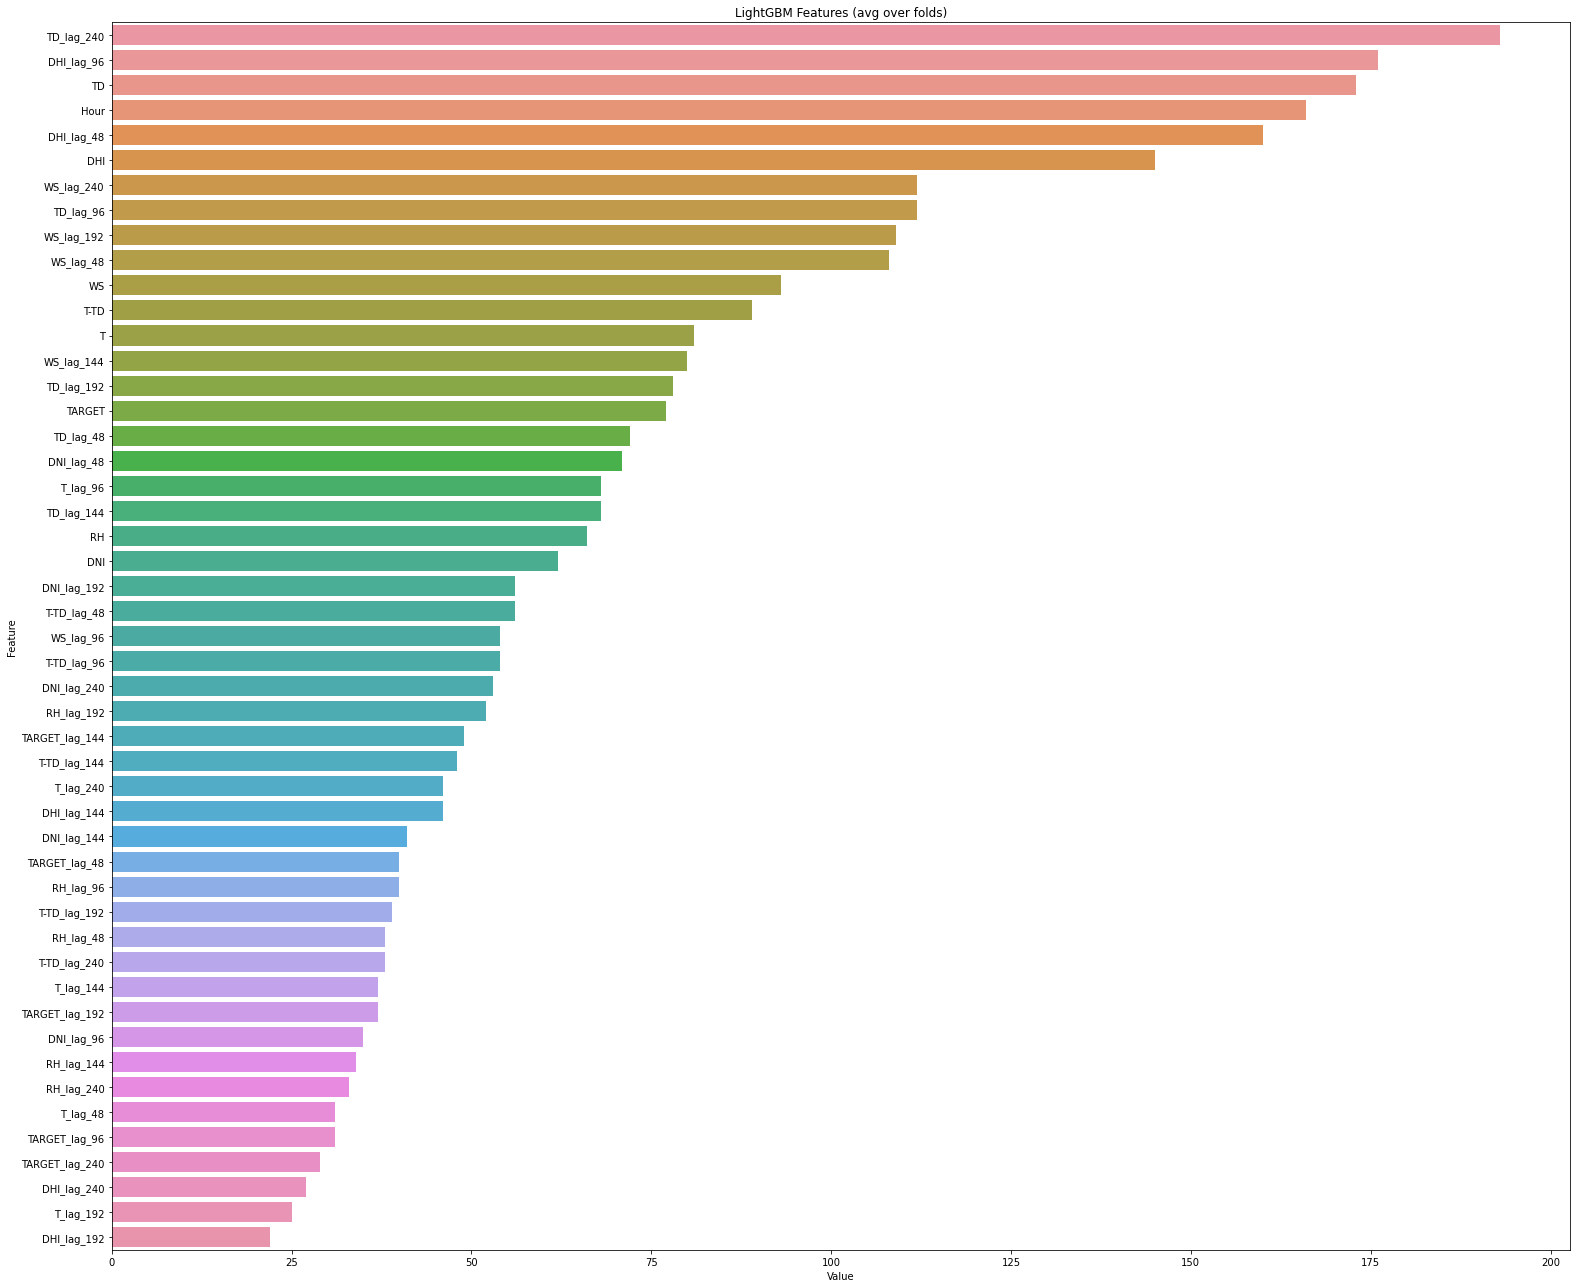

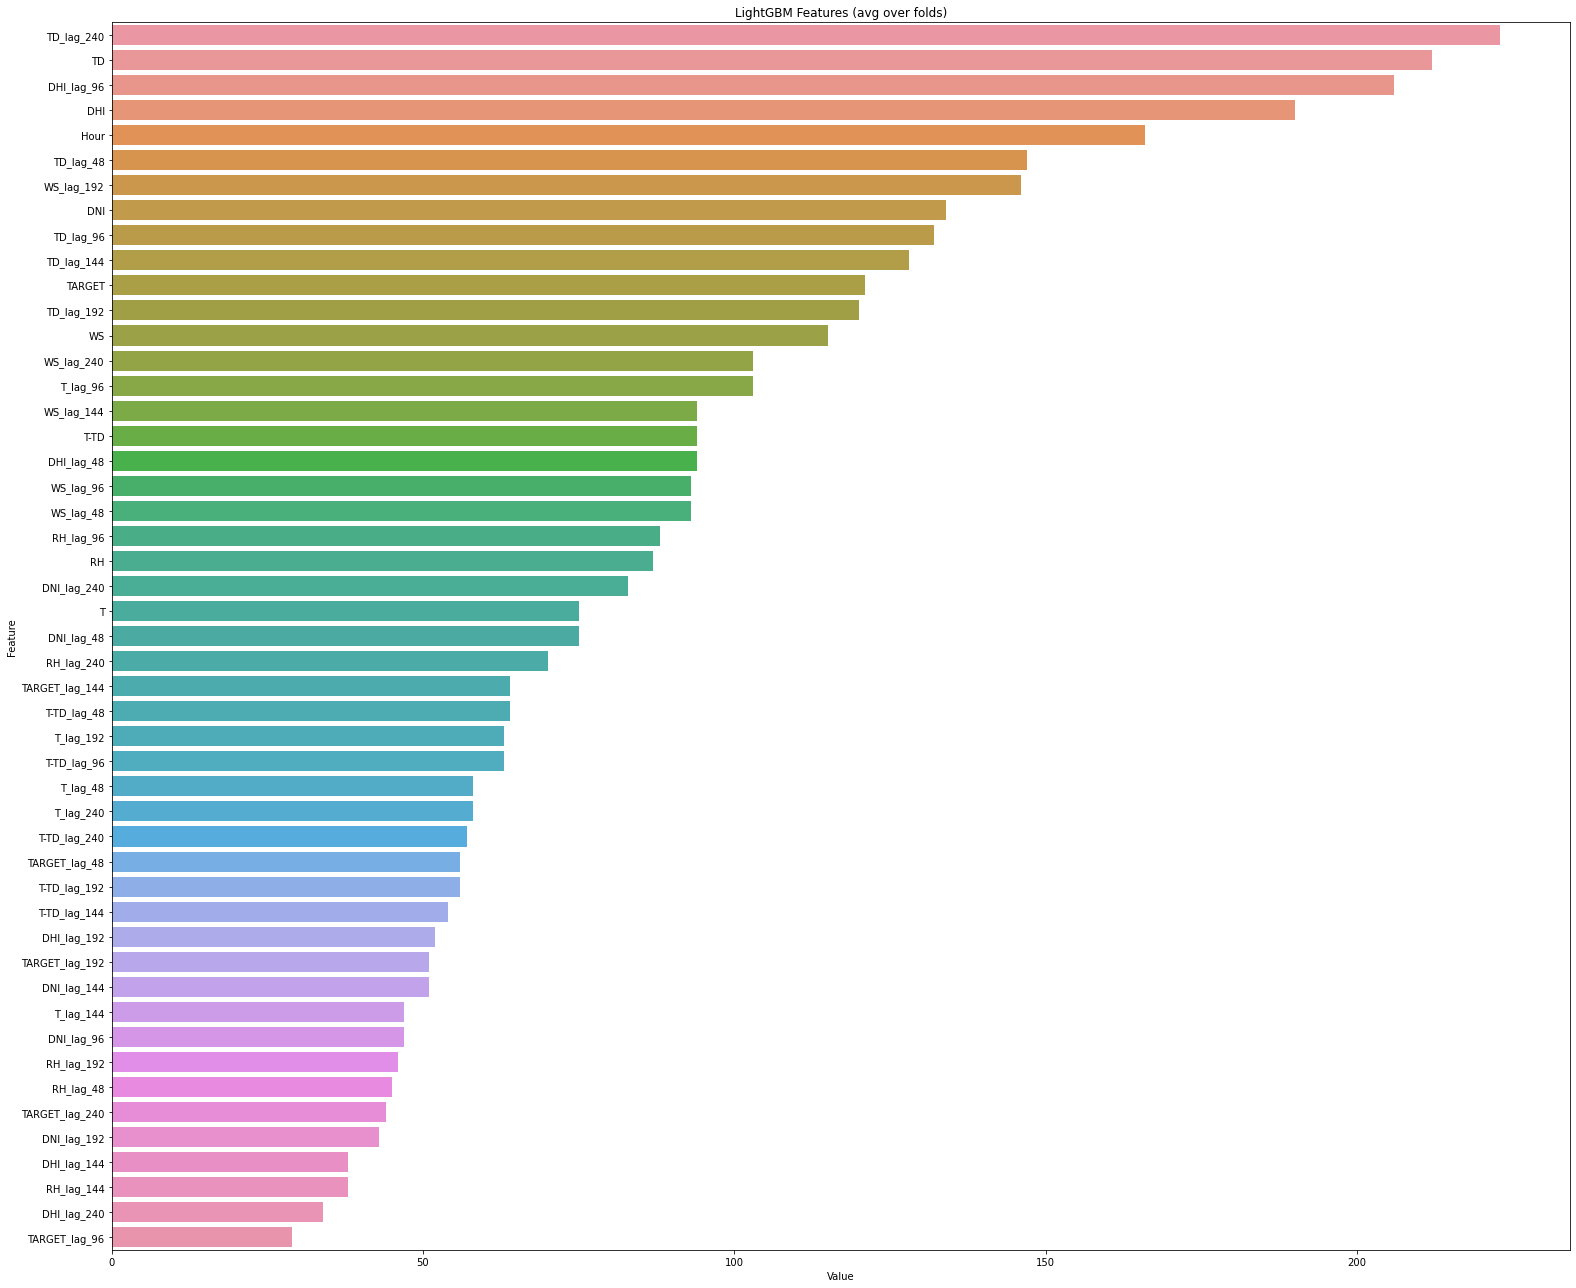

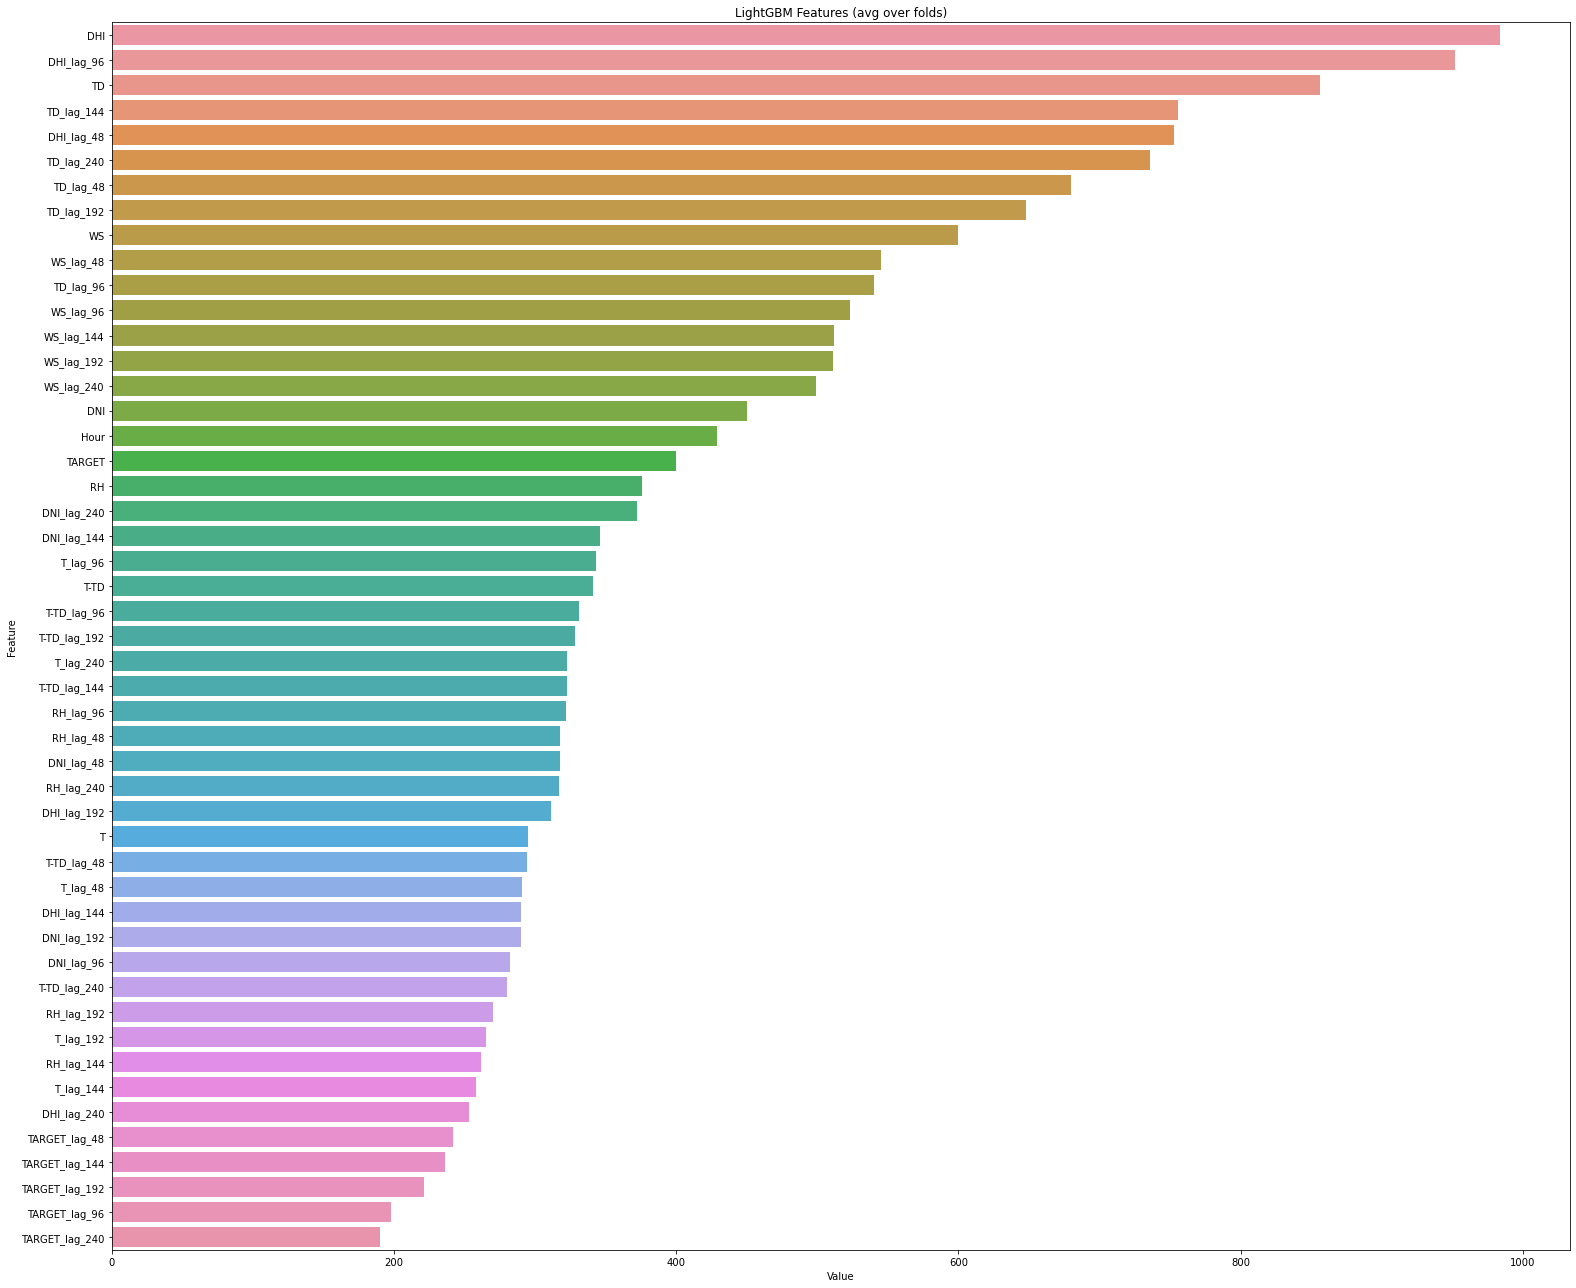

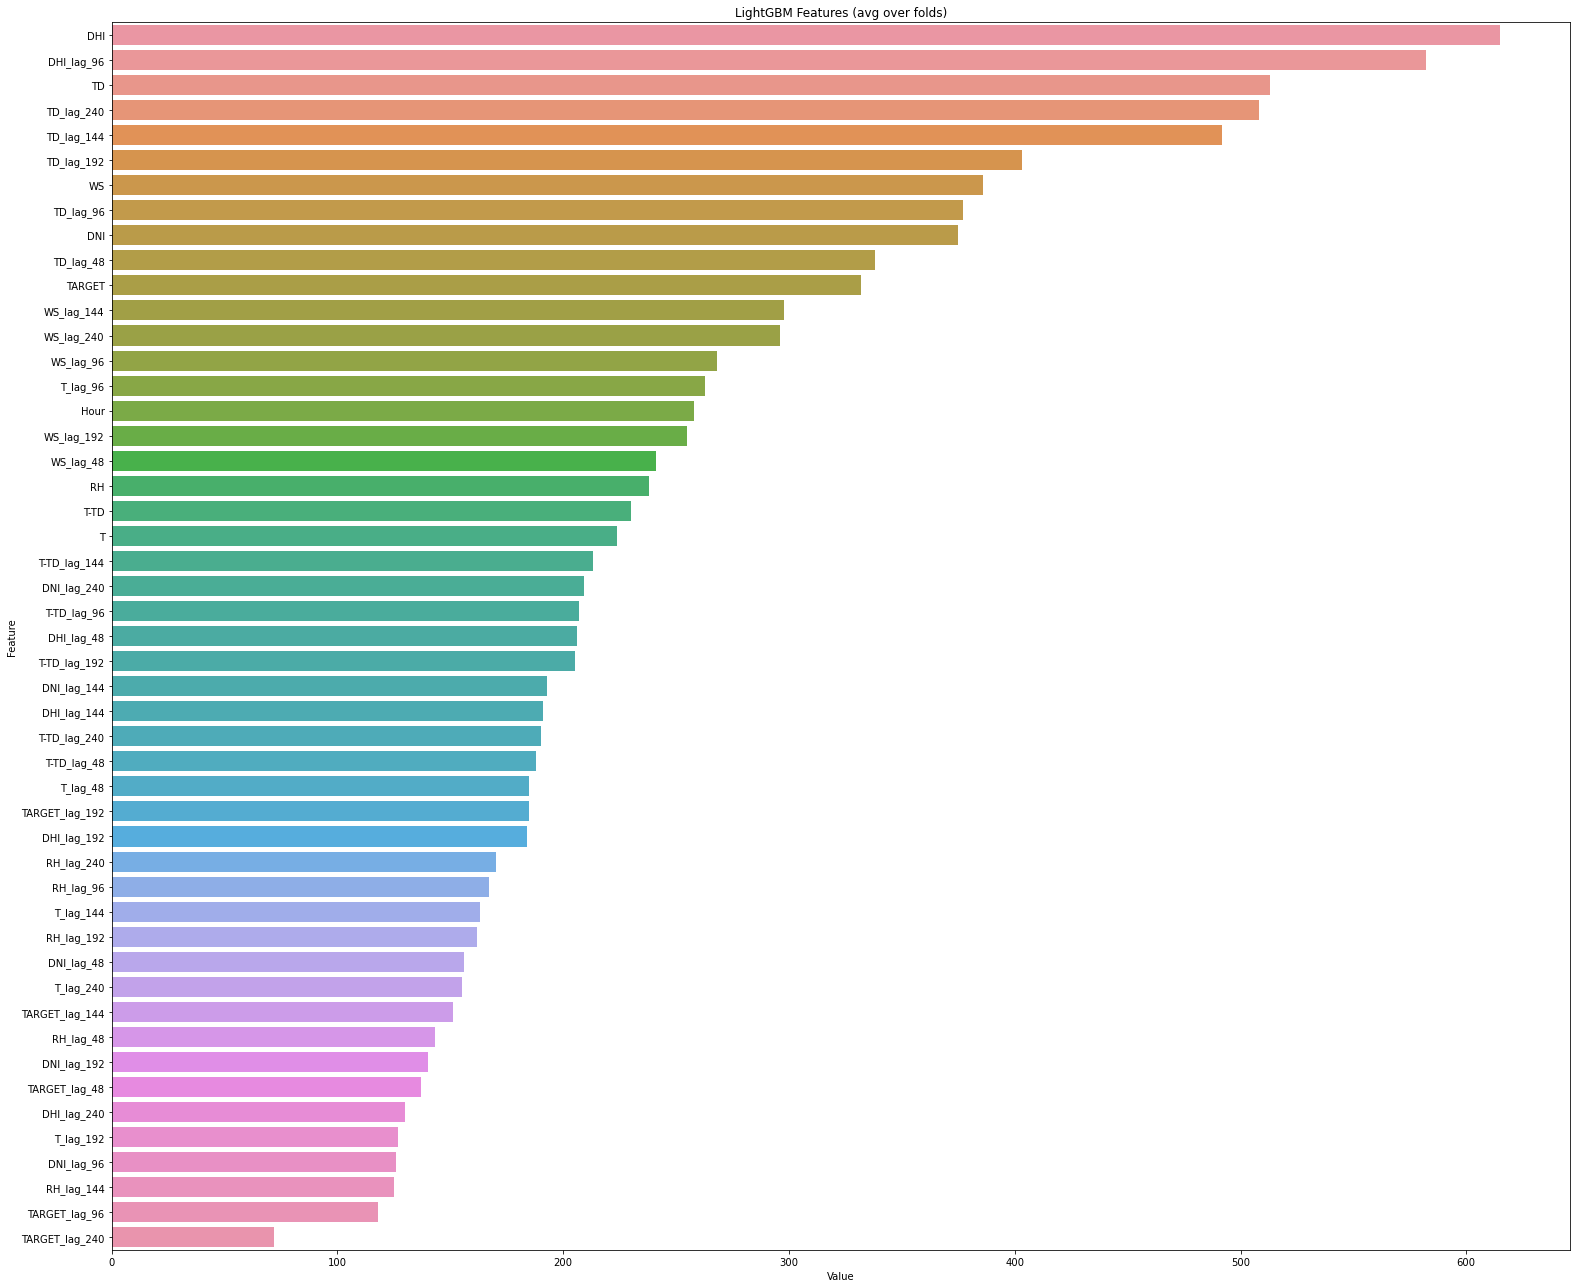

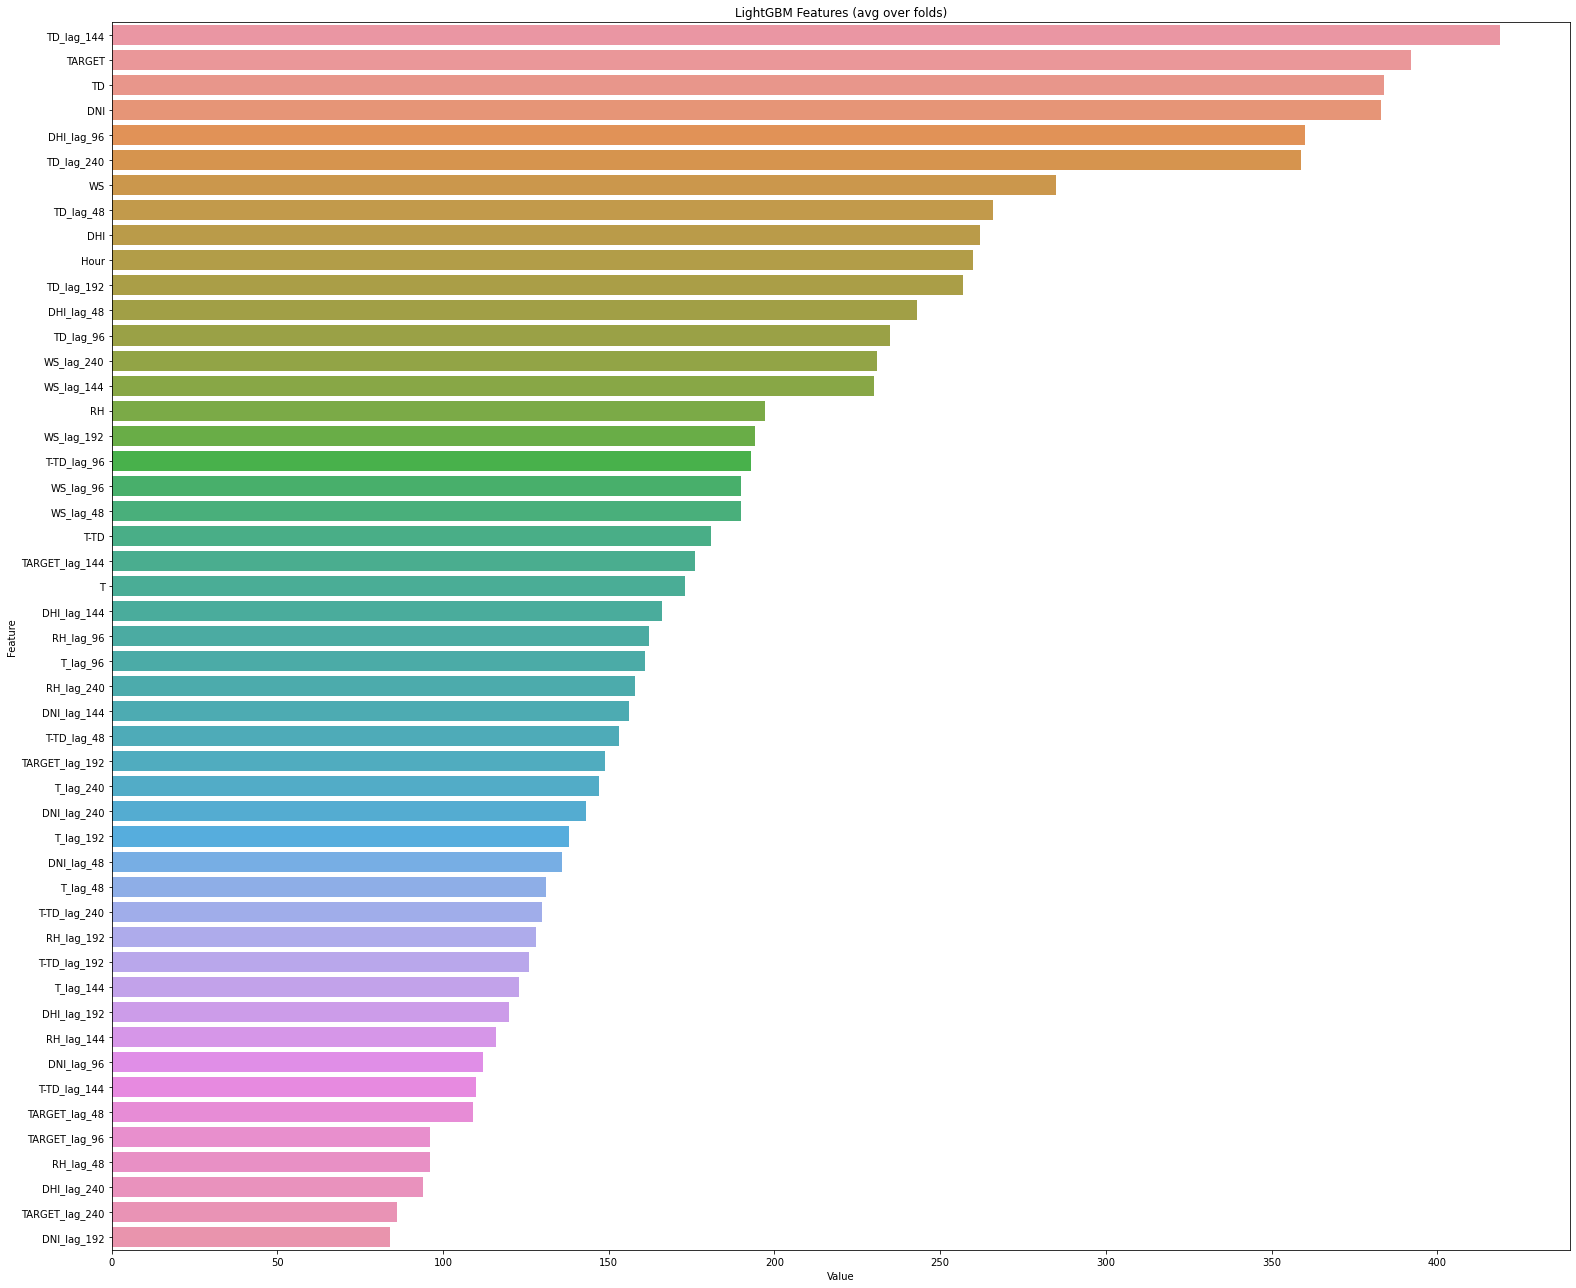

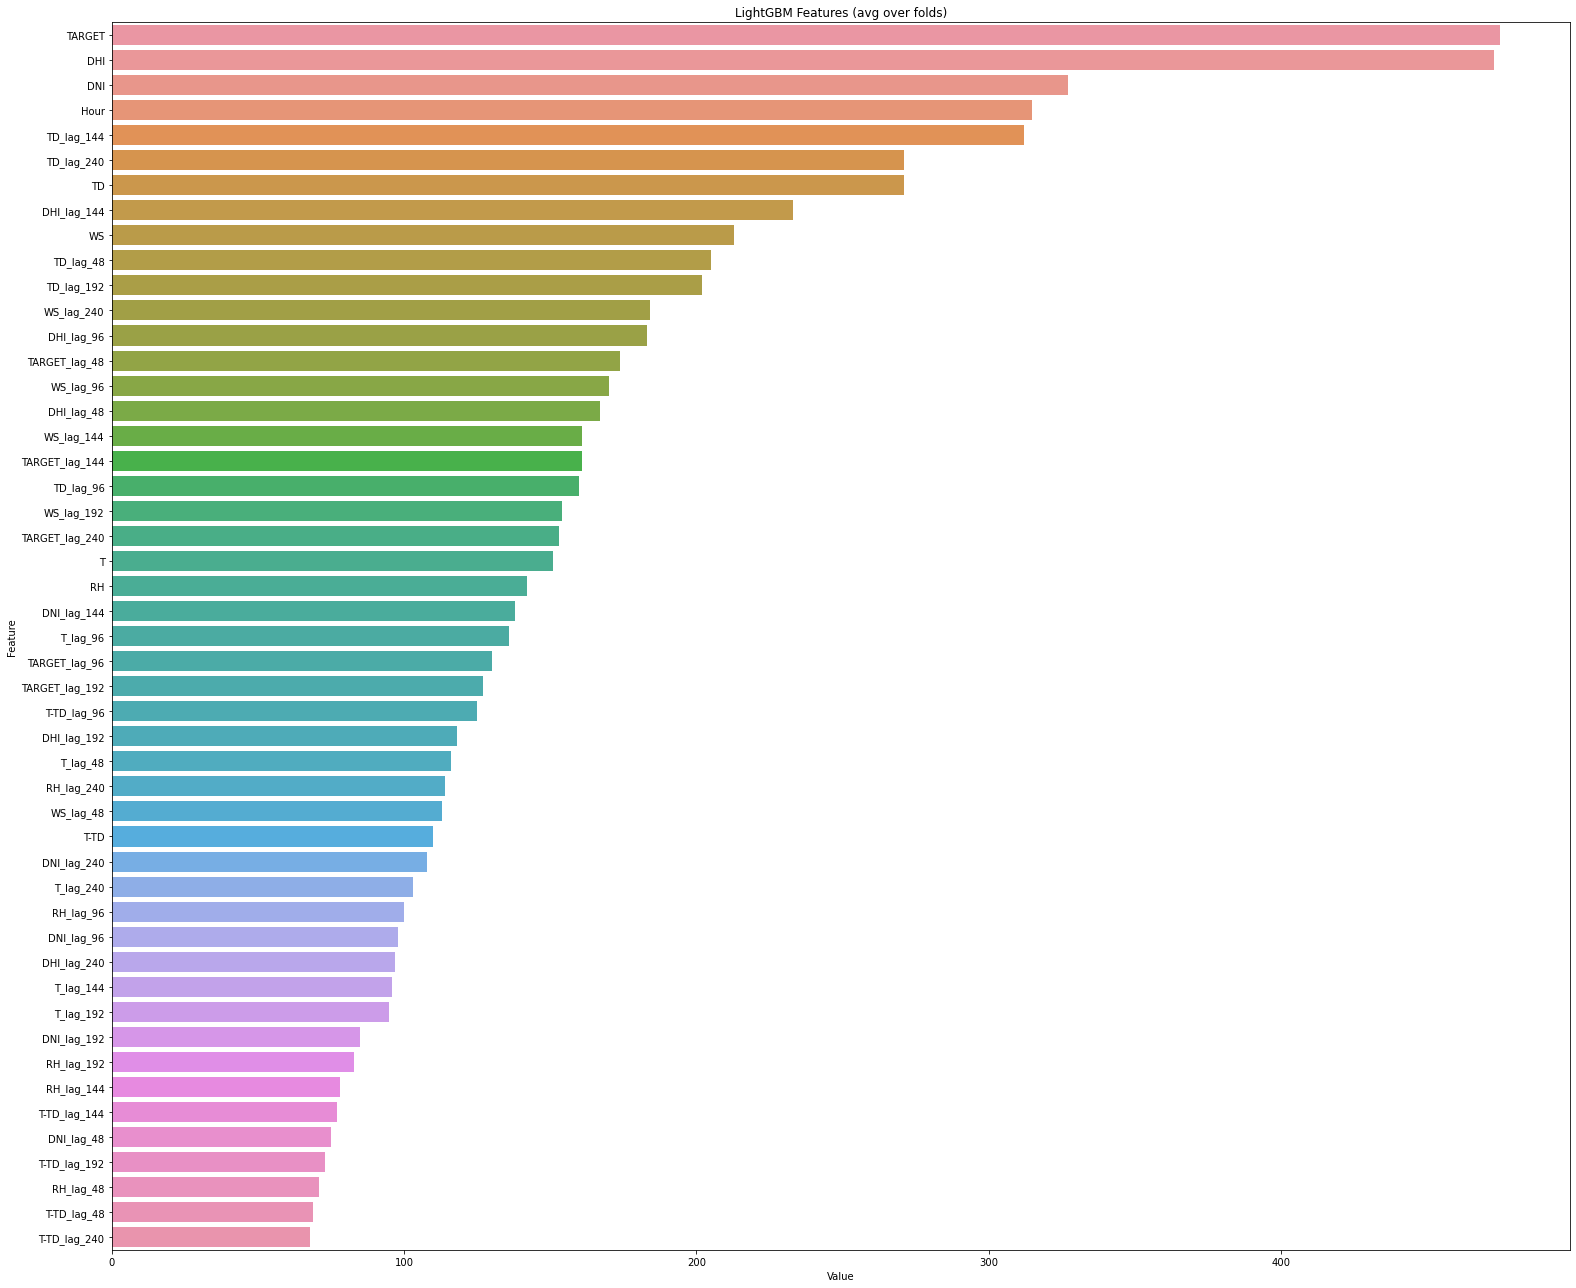

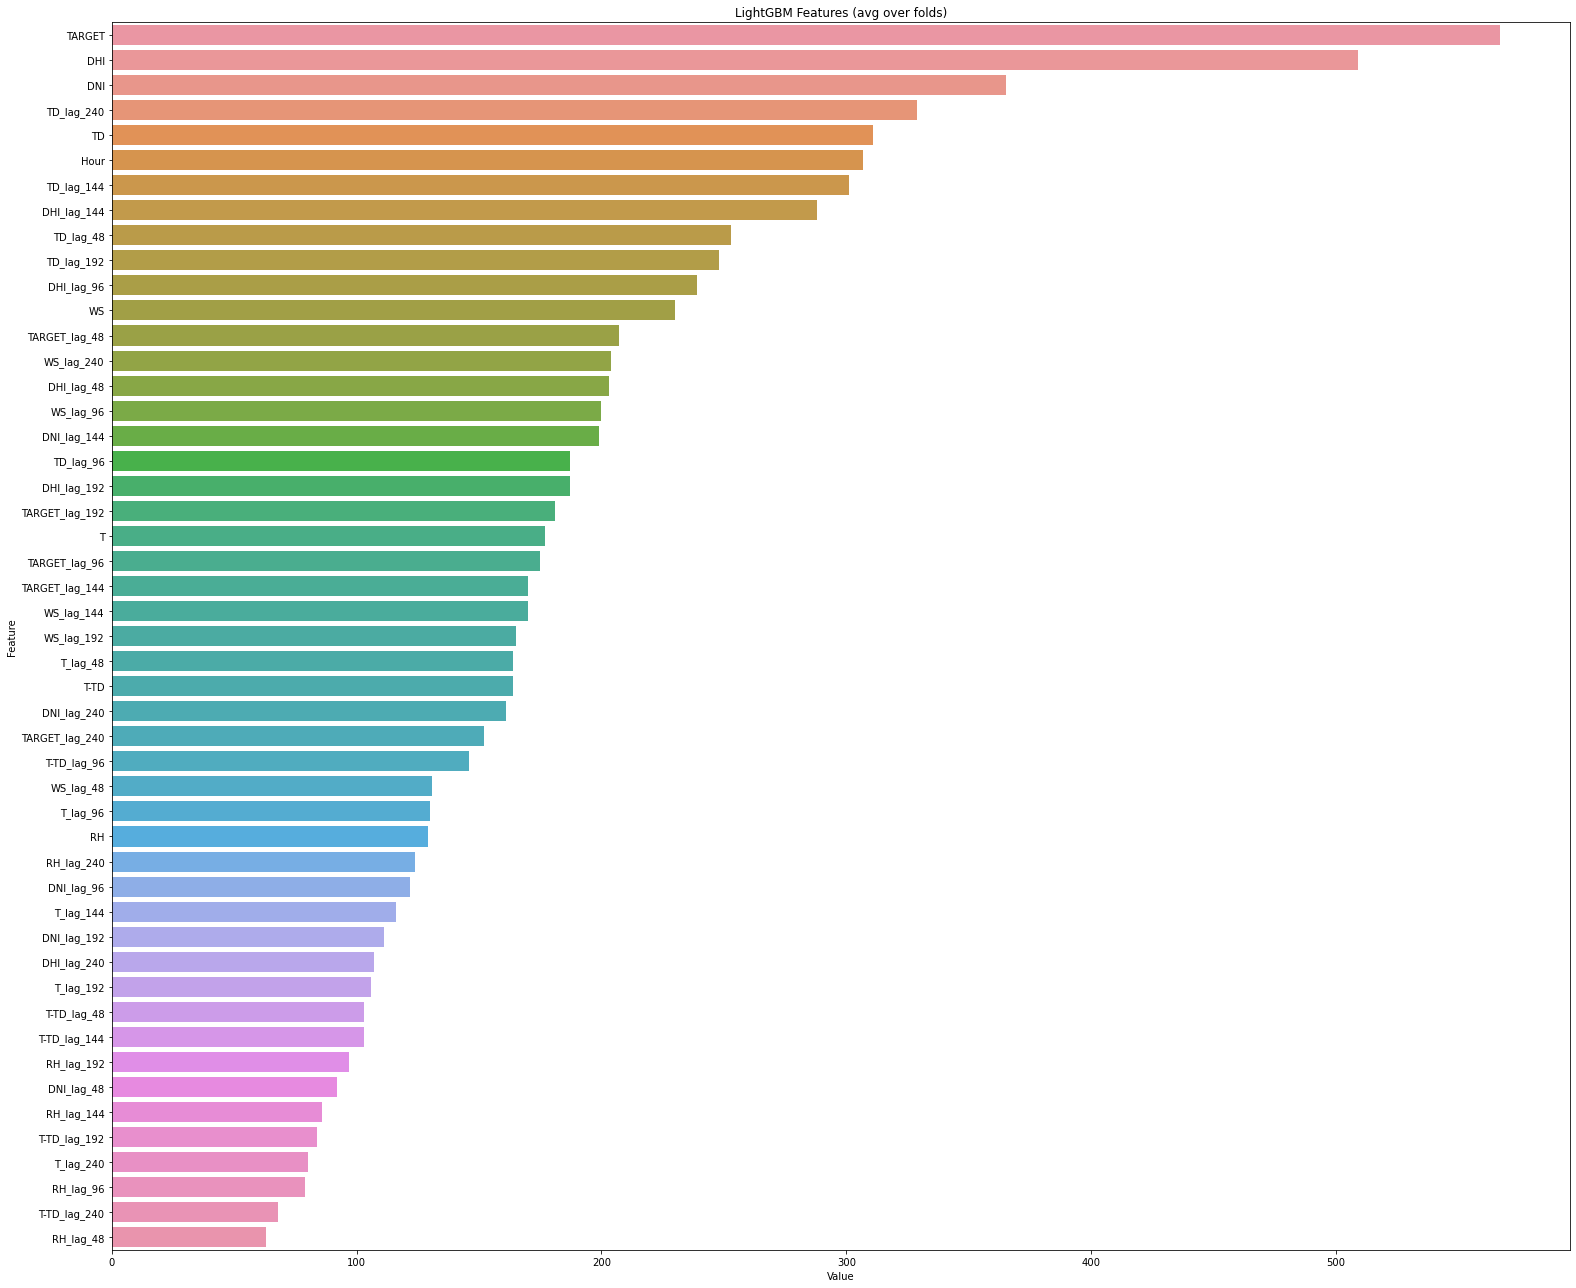

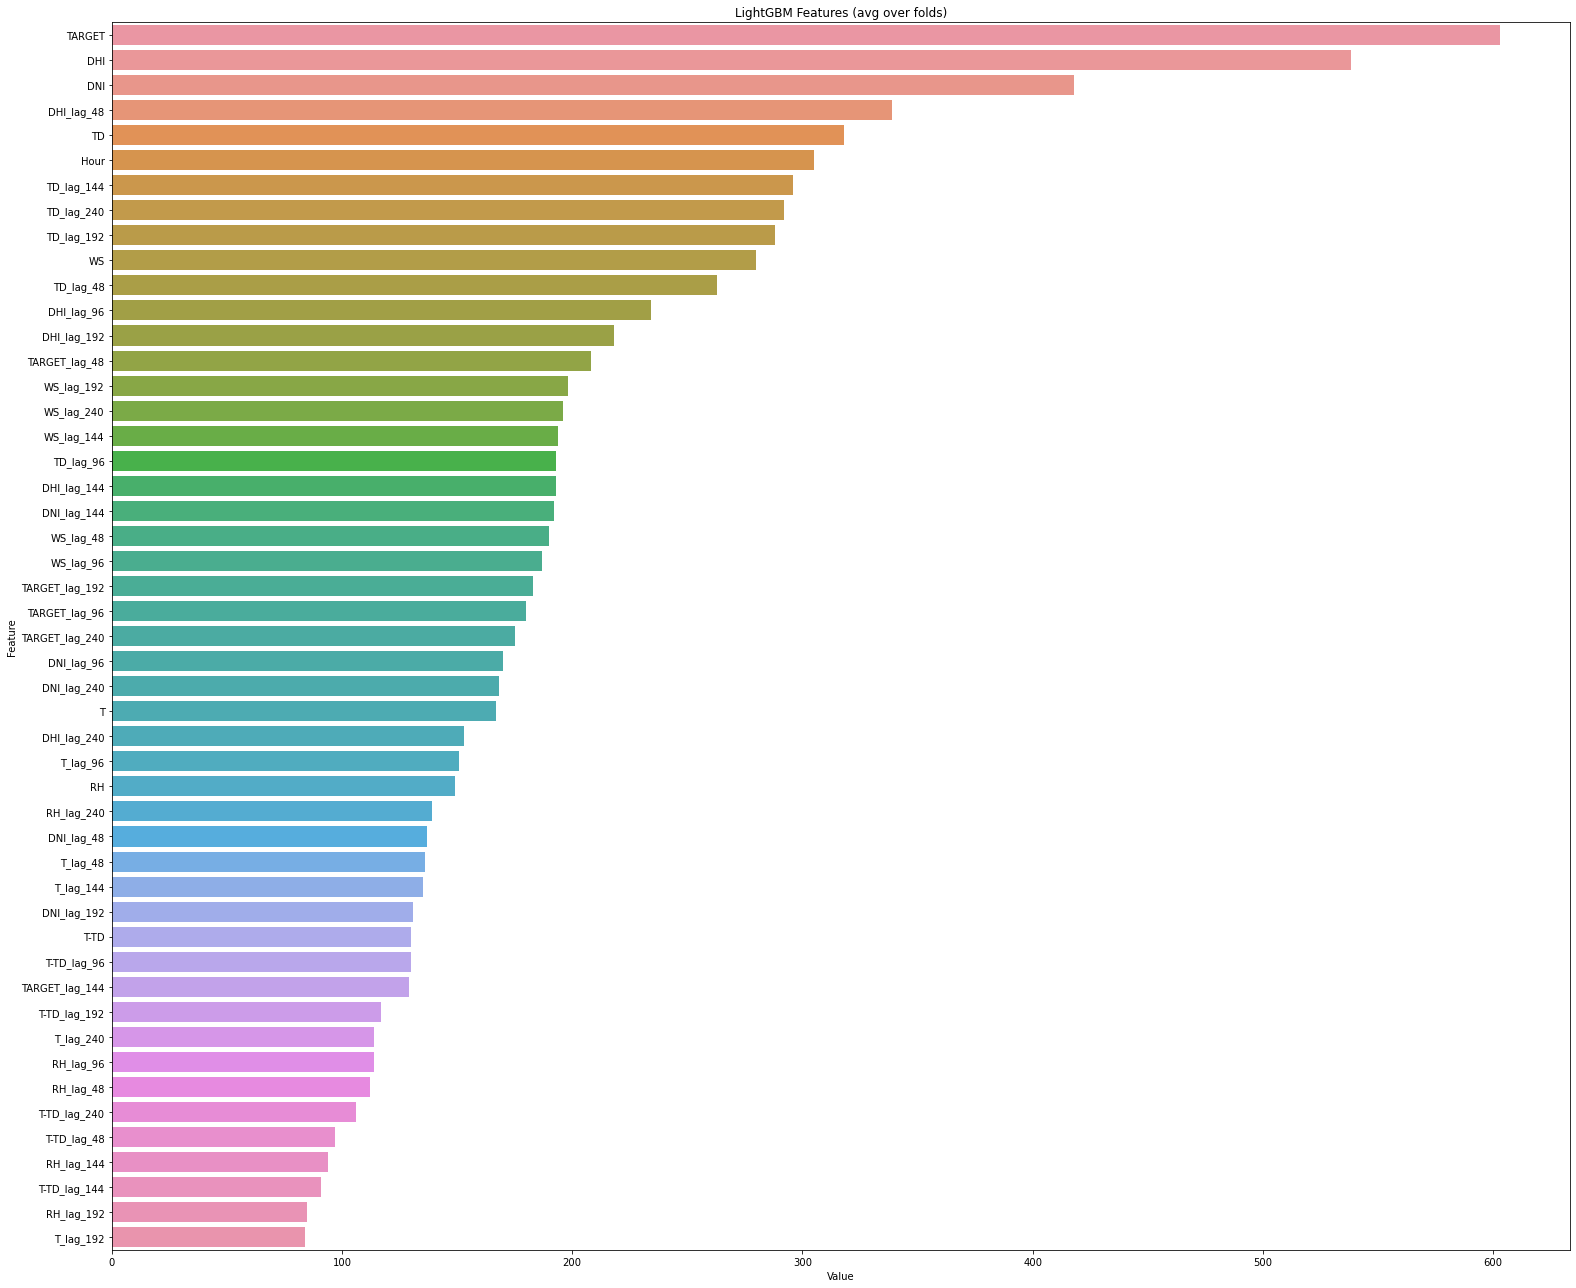

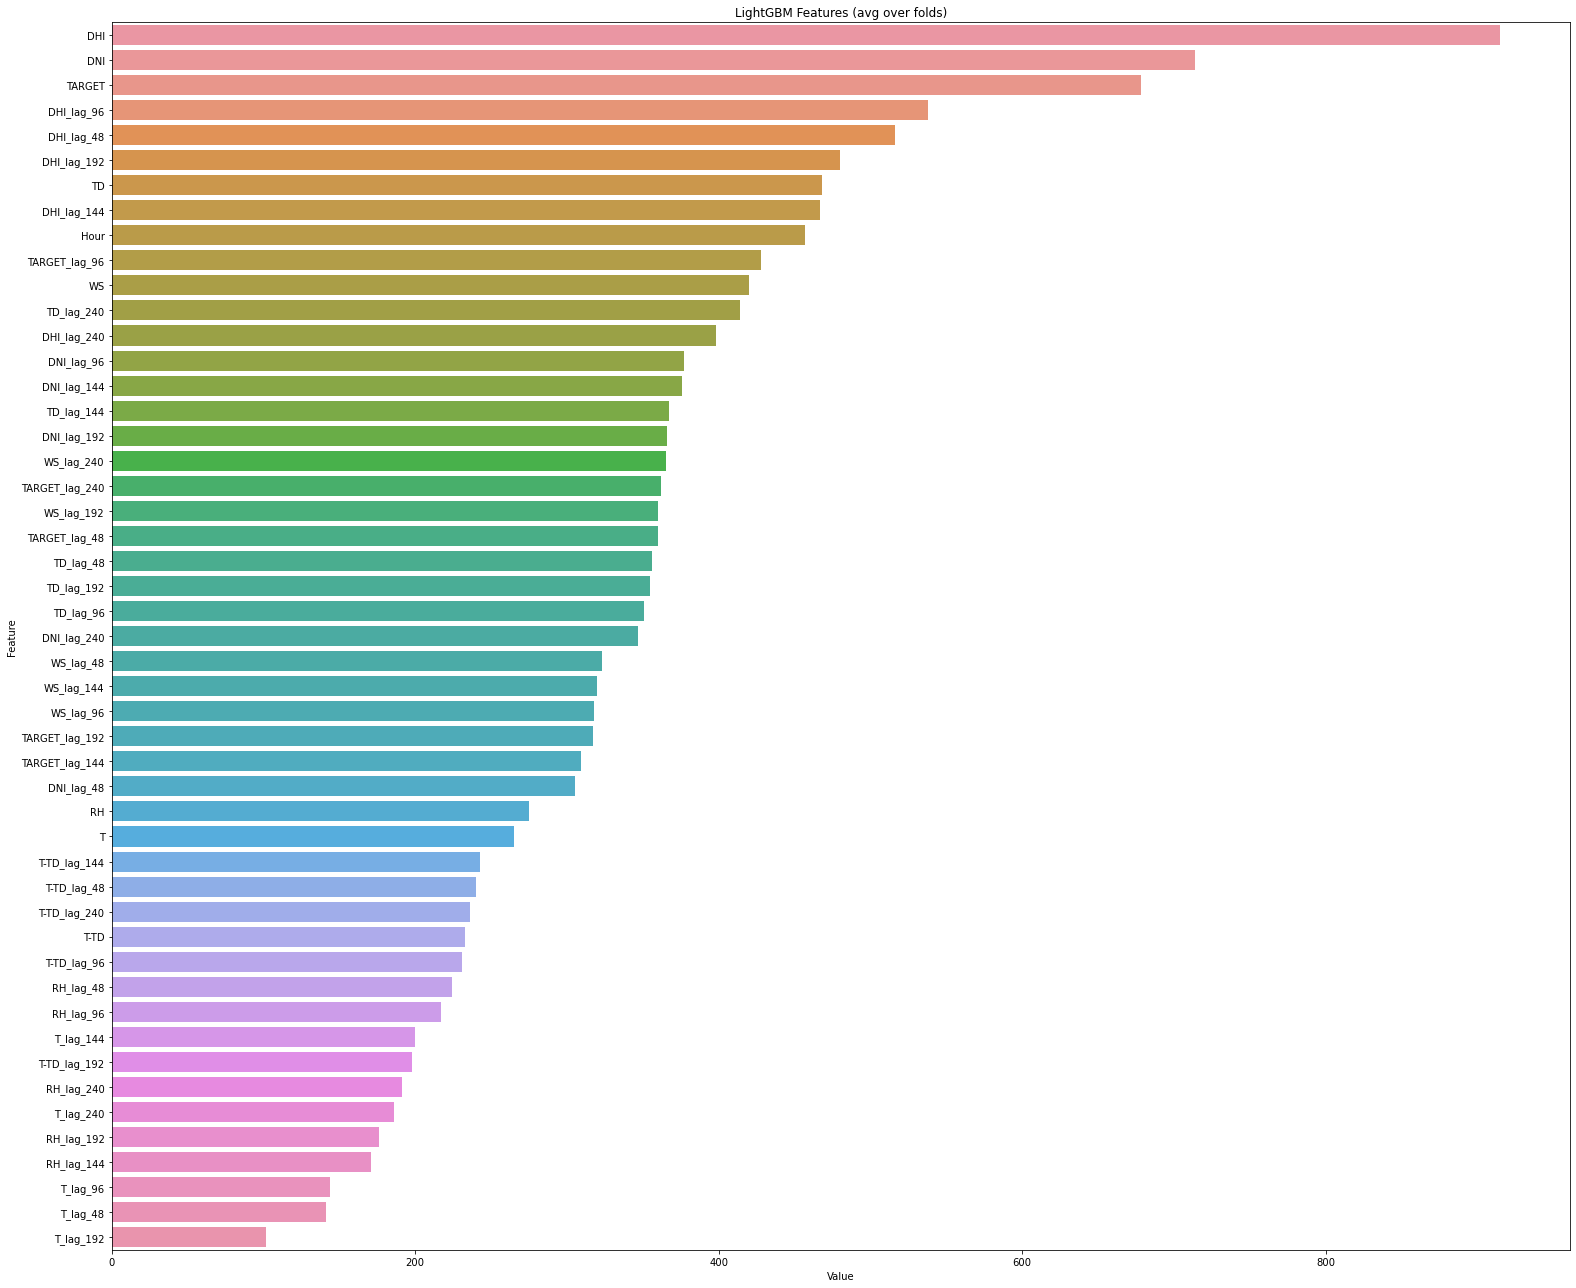

In [48]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(22, 18))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [50]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210119-1_added-ttd.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,2.04,3.06,3.41,3.82,5.88,6.18,6.67,7.29,9.55
17,0.csv_Day7_8h30m,3.84,6.09,6.33,7.28,10.12,10.14,13.62,12.80,16.13
18,0.csv_Day7_9h00m,5.01,7.40,10.00,12.54,14.09,18.29,19.78,21.68,21.13
19,0.csv_Day7_9h30m,7.20,11.50,13.60,15.54,18.49,21.34,26.90,25.57,30.96
20,0.csv_Day7_10h00m,8.15,11.39,15.24,19.43,22.22,24.94,30.04,28.40,33.26
21,0.csv_Day7_10h30m,9.54,15.47,20.14,25.29,26.18,30.14,36.07,37.46,36.94
22,0.csv_Day7_11h00m,11.42,19.24,25.45,30.68,31.29,34.54,41.86,43.08,42.18
23,0.csv_Day7_11h30m,11.46,18.64,25.90,28.42,31.17,36.93,40.38,44.94,44.07
24,0.csv_Day7_12h00m,12.95,19.59,26.61,29.67,33.01,37.70,40.33,45.57,42.87
25,0.csv_Day7_12h30m,13.11,20.14,27.11,31.66,32.71,41.49,42.77,45.18,43.69
